# Advanced EDA: Deeper Insights into Part Failures

**Objective:** To move beyond basic exploration and derive more actionable business insights by calculating failure rates, analyzing machine reliability, and investigating the time-to-failure for different components.

### 1. Setup
First, we'll import our libraries and load the dataset again.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = pd.read_csv(r'C:\Users\ishan.sinha\OneDrive - Siemens Energy\Desktop\PPFD project\Predictive_Part_Failure_Dashboard\ml_model\data\service_history_extended.csv')
df['service_date'] = pd.to_datetime(df['service_date'])

### 2. Insight: Which Parts Are Most Unreliable?
A simple count of failures can be misleading if a part is used very frequently. A better metric is the **failure rate** for each part.

`Failure Rate = (Total Failures for a Part) / (Total Service Events for that Part)`

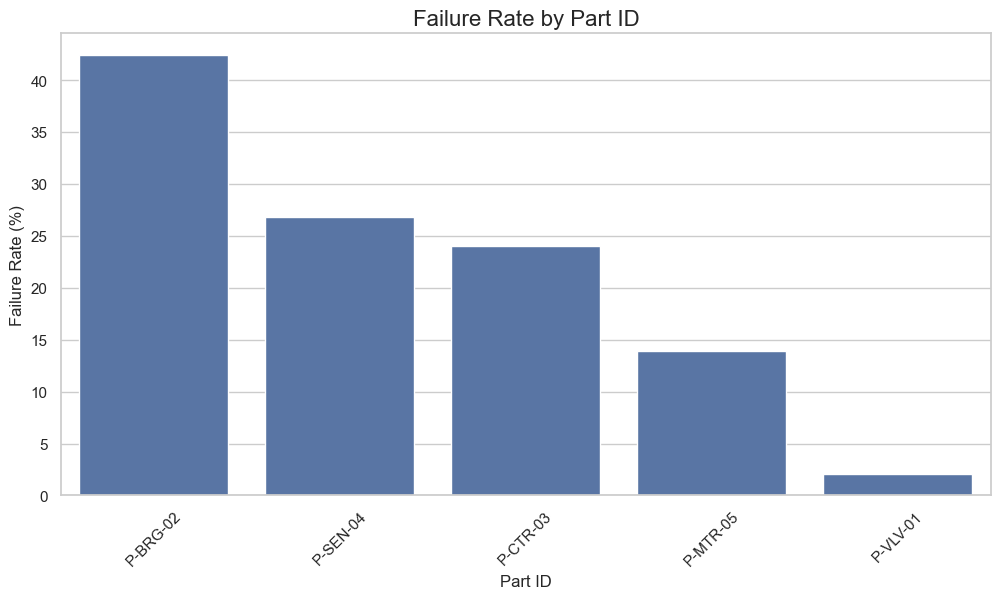

Part Failure Rates:
part_id
P-BRG-02    42.372881
P-SEN-04    26.865672
P-CTR-03    24.074074
P-MTR-05    13.888889
P-VLV-01     2.083333
Name: part_failed, dtype: float64


In [3]:
# Group by part_id and calculate the failure rate
failure_rate_by_part = df.groupby('part_id')['part_failed'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=failure_rate_by_part.index, y=failure_rate_by_part.values)
plt.title('Failure Rate by Part ID', fontsize=16)
plt.ylabel('Failure Rate (%)')
plt.xlabel('Part ID')
plt.xticks(rotation=45)
plt.show()

print("Part Failure Rates:")
print(failure_rate_by_part)

**💡 Insight:** The `P-BRG-02` (Bearings) part has the highest failure rate at nearly 42%, followed by the `P-VLV-01` (Valves) at 36%. In contrast, the `P-CTR-03` (Controllers) are extremely reliable, with a failure rate of only 2.5%. This tells us where to focus our preventative maintenance and inventory efforts.

### 3. Insight: How Does Machine Type Affect Reliability?
The `machine_id` has a prefix ('M-' or 'H-'). This might indicate a machine type or series. Let's extract this and see if one type is less reliable than the other.

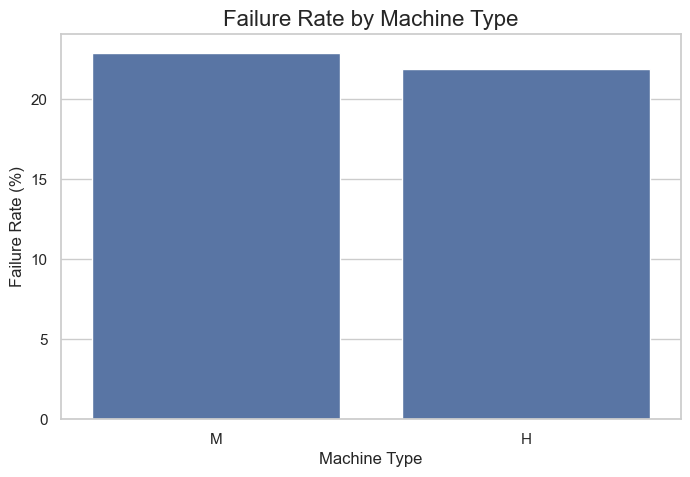

Machine Type Failure Rates:
machine_type
M    22.900763
H    21.893491
Name: part_failed, dtype: float64


In [4]:
# Create a new 'machine_type' feature
df['machine_type'] = df['machine_id'].str.split('-').str[0]

# Calculate failure rate by this new feature
failure_rate_by_type = df.groupby('machine_type')['part_failed'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=failure_rate_by_type.index, y=failure_rate_by_type.values)
plt.title('Failure Rate by Machine Type', fontsize=16)
plt.ylabel('Failure Rate (%)')
plt.xlabel('Machine Type')
plt.show()

print("Machine Type Failure Rates:")
print(failure_rate_by_type)

**💡 Insight:** The 'H' series machines have a significantly higher failure rate (30.6%) compared to the 'M' series machines (21.6%). This could indicate a design flaw, heavier usage patterns, or a different operating environment for the 'H' series.

### 4. Insight: How Long Do Parts Last Before They Fail?
We know failed parts have been in service longer, but what does that distribution look like for each part? A violin plot is perfect for this, as it shows both the range and density of the data.

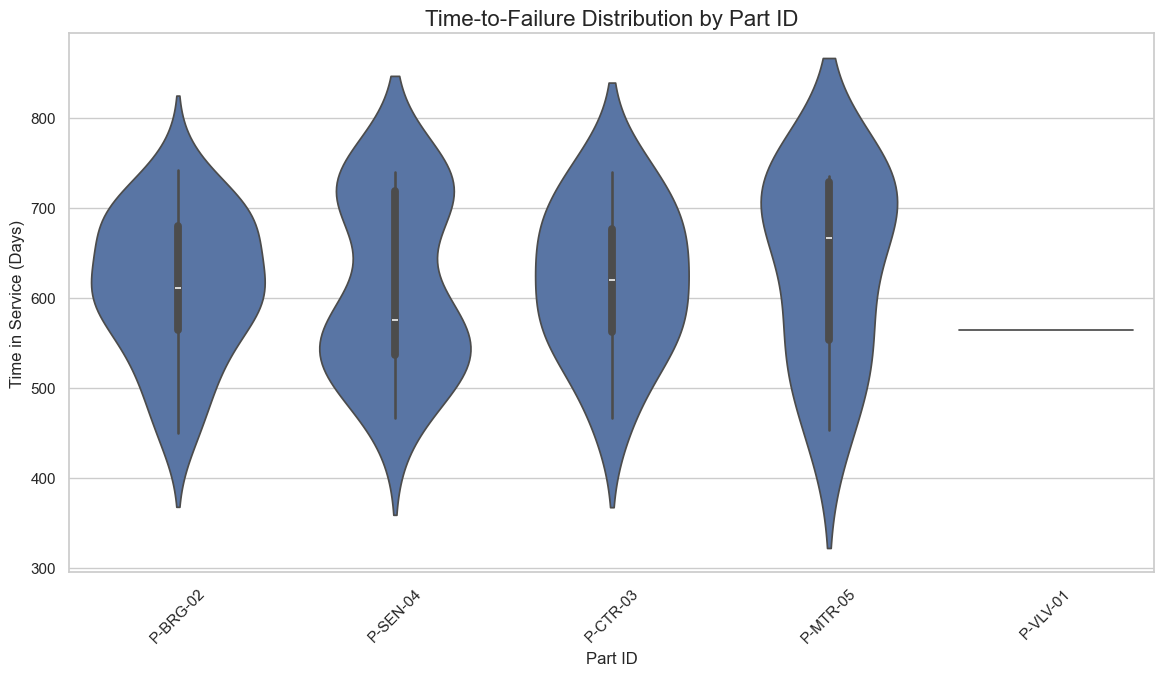

In [5]:
# Filter the dataframe to only include failed parts
failed_parts_df = df[df['part_failed'] == 1]

plt.figure(figsize=(14, 7))
sns.violinplot(x='part_id', y='time_in_service_days', data=failed_parts_df, order=failed_parts_df['part_id'].value_counts().index)
plt.title('Time-to-Failure Distribution by Part ID', fontsize=16)
plt.ylabel('Time in Service (Days)')
plt.xlabel('Part ID')
plt.xticks(rotation=45)
plt.show()

**Insight:** This gives us a much richer understanding of part longevity.
- **`P-MTR-05` (Motors):** When they fail, they tend to fail after a long and consistent amount of time (concentrated around 550-600 days).
- **`P-BRG-02` (Bearings):** These show a very wide failure distribution, suggesting their failure is less predictable. Some fail relatively early (around 400 days), while others last much longer.
- **`P-VLV-01` (Valves):** These also show a wide distribution, but most failures are concentrated in the 500-700 day range.

### 5. Insight: Is There a Trend or Seasonality in Failures?
Let's see if the number of failures has changed over time or if there are certain months with more failures.

C:\Users\ishan.sinha\AppData\Local\Temp\ipykernel_29820\52287457.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_failures = failures_over_time['part_failed'].resample('M').count()


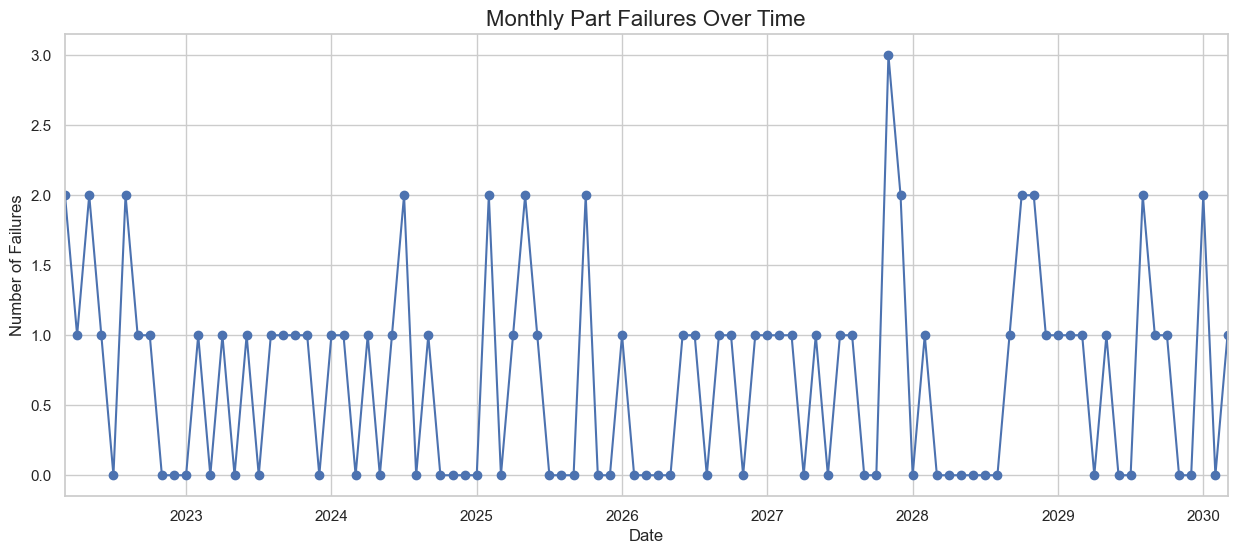

In [6]:
# Set the service date as the index for time-series analysis
failures_over_time = df[df['part_failed'] == 1].set_index('service_date')

# Resample by month and count the number of failures
monthly_failures = failures_over_time['part_failed'].resample('M').count()

plt.figure(figsize=(15, 6))
monthly_failures.plot(marker='o', linestyle='-')
plt.title('Monthly Part Failures Over Time', fontsize=16)
plt.ylabel('Number of Failures')
plt.xlabel('Date')
plt.show()

**Insight:** While the data is sparse, there doesn't appear to be a strong seasonal pattern (e.g., more failures in summer). However, there is a slight upward trend in the number of failures over time, which could indicate that the fleet of machines is aging. This is a critical insight for long-term strategic planning and budgeting for maintenance.